In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

In [249]:
def make_test_df(train_df):
    #print(train_df)
    species_sites = train_df['site_id'].unique()
        
    #print(species_sites)
    
    site_ripenesses = []

    for site in species_sites:
        site_df = train_df[train_df['site_id'] == site]

        site_ripenesses.append({
            'site_id': site,
            'doy': np.mean(site_df['doy'])
        })

    species_test_df = pd.DataFrame(site_ripenesses)
    species_test_df['year'] = high_cutoff_year
    
    species_test_df['formatted_sci_name'] = train_df['formatted_sci_name'].iloc[0]
    
    return species_test_df

# More specific to our uses.
def train_ripeness_small(observations, predictors, test_observations, test_predictors, model_name = 'ThermalTime'):

    print("running model {m}".format(m=model_name))
    Model = utils.load_model(model_name)
    model = Model()
    model.fit(observations, predictors, optimizer_params='practical')
    
    print(model)
    
    print("making predictions for model {m}".format(m=model_name))
    
    pred_list = []
    
    # assuming year is the same for both test obs and test preds
    for s in test_observations['site_id'].unique():
        site_obs = test_observations[test_observations['site_id'] == s]
        site_prediction = model.predict(site_obs, test_predictors)
        
        if len(site_prediction) > 0 and site_prediction[0] < 999:
            pred_list.append({
                'site_id': s,
                'formatted_sci_name': test_observations['formatted_sci_name'].iloc[0],
                'prediction': site_prediction[0],
                'doy': site_obs['doy'].iloc[0]
            })
        
    #print(pred_list)
    
    pred_df = pd.DataFrame.from_records(pred_list)
    
    #print(pred_df)
    
    preds = pred_df['prediction']
    test_days = pred_df['doy']
    sites = pred_df['site_id']

    if len(preds) == 0:
        print(test_observations)
        print(test_predictors)
    
    #print(pred_list)
   
    # Various error types
    model_mae = mae(test_days, preds)
    model_rmse = rmse(test_days, preds)
    median_error = np.median(np.abs(test_days - preds))

    print('model {m} got a MAE of {a}'.format(m=model_name,a=model_mae))
    print('model {m} got an RMSE of {a}'.format(m=model_name,a=model_rmse))
    print('model {m}\'s median error is: {a}'.format(m=model_name,a=median_error))

    print("Ripeness Day: {}".format(np.mean(preds)))
    
    #filtered_test_observations = test_observations[test_observations['site_id'].isin(sites)]
    
    ripeness_data = pred_df
    ripeness_data['ripeness_day'] = ripeness_data['prediction']
    
    ripeness_dict = {
        'model_object': model,
        'MAE': model_mae,
        'RMSE': model_rmse,
        'Median Error': median_error,
        'prediction_df': ripeness_data,
    }
    
    return ripeness_dict

Idea for corrections: take the lower error between the base error and the year-transformed error.


Best Approach is:
- High time resolution, correcting for missing data by using averaged data from previous years.
- Add European Weather data.
- No southern hemisphere. 
- Corrected error (i.e. date wrapping). 

Best reporting statistic: what portion of results lie under X.
For example, 80% of results lie under 1 STD, 95% lie under 2 STD. 
Can make a "confidence score" from this – percentile error? Ex. This is less error than 90% of things.  

In [100]:
# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/monthly_weather_data.grib')

core_data = grib_data[0]

print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

#rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(formatted_plants['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(formatted_plants['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
#rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_plants['coordstring'] = formatted_plants['rounded_lat'].astype(str) + formatted_plants['rounded_lon'].astype(str)

formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

formatted_plants['site_id'] = formatted_plants['coordstring'].str.replace(".", "")
formatted_weather['site_id'] = formatted_weather['coordstring'].str.replace(".", "")

## Add Site ID to the weather data
#weather_with_sites = pd.merge(formatted_weather, formatted_plants[['coordstring', 'site_id']], on='coordstring')#.drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
print("separating weather data")
formatted_weather = formatted_weather[formatted_weather['year'] != 2023]

# 
print("converting to Celsius")
formatted_weather['temperature'] = formatted_weather['temperature'] - 272.15

#weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
#weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = formatted_weather['site_id'].unique()

print("filtering plant data")
filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]

aggressive_filtered_plants = filtered_plants.query('doy >= 145 and doy <= 314')


loading weather data
Loading Plant Data
filtering weather data
formatting weather data
formatting date columns
correcting leap years
adding site IDs to weather data
separating weather data
converting to Celsius
formatting plant data
filtering plant data


In [73]:
euro_data = load_euro_weather_data(euro_path, '../data/high_res_euro_stations.csv')

In [74]:
## Make site ID column of euro data from coordstring

print("constructing european site IDs")
euro_data['site_id'] = euro_data['coordstring'].str.replace(".", "")

# Make sure to drop duplicate sites/coordstrings?
print("filtering euro data")
filtered_euro = euro_data[euro_data['site_id'].isin(formatted_weather['site_id'].unique())]

# merge euro data with monthly 

constructing european site IDs
filtering euro data


In [77]:
euro_sites = euro_data['site_id'].unique()

unmutual_sites = formatted_weather[~formatted_weather['site_id'].isin(euro_sites)]

Problem is with the merge on mutual sites. 

In [192]:
## STATS

# get confidence intervals for species

def calc_confidence_interval():
    pass

def score_model(prediction_df):
    observed = prediction_df['doy']
    predicted = prediction_df['ripeness_day']
    
    median_err = np.median(prediction_df['abs_error'])
    std = np.std(prediction_df['abs_error'])
    
    # MAE, RMSE, median
    print("Error metrics:")
    print("MAE:", mae(observed, predicted))
    print("RMSE:", rmse(observed, predicted))
    print("Median Absolute Error:", median_err)
    
    # portion of errors under the median
    print("Median portion (median error = {})".format(median_err))
    print(len(prediction_df.query('abs_error < {}'.format(median_err))) / len(prediction_df))
    
    # portion of errors under the SD
    print("SD portion (SD = {})".format(std))
    print(len(prediction_df.query('abs_error < {}'.format(std))) / len(prediction_df))
    
    print("Month threshold:")
    print(len(prediction_df.query('abs_error < 30')) / len(prediction_df))

    # 
    print("2 * SD portion (2SD = {})".format(2 * std))
    print(len(prediction_df.query('abs_error < {}'.format(2 * std))) / len(prediction_df))
    

# get how "good" one sample is compared to the whole sample
def calc_error_percentile(sample, full_sample):
    sample_median = np.median(sample['abs_error'])
    
    print(sample_median)
    print(1 - len(full_sample.query('abs_error < {}'.format(sample_median))) / len(full_sample))

In [232]:
def train_species_models(full_plant_data, full_weather_data):
    # Separate weather data into train and test
    weather_training = full_weather_data[full_weather_data['year'] < high_cutoff_year]
    weather_test = full_weather_data[full_weather_data['year'] >= high_cutoff_year]
    
    species_prediction_dict = {}
    species_list = full_plant_data['formatted_sci_name'].unique()
    print(species_list)

    for s in tqdm(species_list):
        print("\n\n", s)
        species_train_df = full_plant_data.query('formatted_sci_name == "{}" and year < {}'.format(s, high_cutoff_year))
        
        if len(species_train_df) <= 10:
            print("not enough training data")
            continue        

        species_test_df = full_plant_data.query('formatted_sci_name == "{}" and year >= {}'.format(s, high_cutoff_year))

        if len(species_test_df) == 0:
            print("No test data for {}".format(s))
            # make predictions and compare to the mean ripeness day at each site
            species_test_df = make_test_df(species_train_df)

        if len(species_test_df) == 0:
            print("No test data for {}, after attempt at rectification".format(s))
            #print(species_test_df)
            
        filtered_weather_test = weather_test[weather_test['site_id'].isin(species_test_df['site_id'])]
        filtered_species_test = species_test_df[species_test_df['site_id'].isin(filtered_weather_test['site_id'])]
        
        #print(species_train_df, weather_training)
        #print(species_test_df)
        #print(filtered_weather_test)
        #print(np.sort(filtered_species_test['site_id'].unique()))
        #print(np.sort(filtered_weather_test['site_id'].unique()))

        predictions = train_ripeness_small(species_train_df, weather_training,
                            filtered_species_test, filtered_weather_test)

        #break
        
        species_prediction_dict[s] = predictions
    
    #print(species_prediction_dict)
        
    # gets a list of all the prediction dataframes from the species model
    df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

    full_prediction_df = pd.concat(df_list)

    full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['ripeness_day'])
    
    #print(score_model(full_prediction_df))
    
    return full_prediction_df


In [190]:
euro_observations = filtered_plants[filtered_plants['site_id'].isin(filtered_euro['site_id'])]


In [250]:
normal_training_euro = train_species_models(euro_observations, filtered_euro)

['Ficus' 'Olea europea' 'Rubus' 'Citrus sinensis' 'Prunus domestica'
 'Prunus cerasifera' 'Prunus' 'Malus domestica' 'Malus' 'Malus pumila'
 'Juglans' 'Prunus avium' 'Cornus mas' 'Prunus cerasus' 'Pyrus communis'
 'Pyrus']


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]



 Ficus
not enough training data


 Olea europea
not enough training data


 Rubus
not enough training data


 Citrus sinensis
not enough training data


 Prunus domestica
No test data for Prunus domestica
running model ThermalTime


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:02<00:06,  1.74it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.923809523809524
model ThermalTime got an RMSE of 18.24294974557298
model ThermalTime's median error is: 10.0
Ripeness Day: 232.6


 Prunus cerasifera
not enough training data


 Prunus
No test data for Prunus
running model ThermalTime


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:07<00:10,  1.15s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.133333333333335
model ThermalTime got an RMSE of 14.548310325715953
model ThermalTime's median error is: 12.0
Ripeness Day: 197.66666666666666


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:54<01:25, 10.70s/it]

model ThermalTime got a MAE of 13.524401602828506
model ThermalTime got an RMSE of 18.343493223249716
model ThermalTime's median error is: 9.583333333333343
Ripeness Day: 246.9448818897638


 Malus
not enough training data


 Malus pumila
not enough training data


 Juglans
not enough training data


 Prunus avium
No test data for Prunus avium
running model ThermalTime
making predictions for model ThermalTime


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [01:34<00:41, 10.34s/it]

model ThermalTime got a MAE of 10.048836124593702
model ThermalTime got an RMSE of 12.45514600735747
model ThermalTime's median error is: 9.0
Ripeness Day: 169.4747474747475


 Cornus mas
not enough training data


 Prunus cerasus
not enough training data


 Pyrus communis
No test data for Pyrus communis
running model ThermalTime
making predictions for model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:00<00:00,  7.53s/it]

model ThermalTime got a MAE of 13.463179788961043
model ThermalTime got an RMSE of 16.7394758336685
model ThermalTime's median error is: 12.0
Ripeness Day: 255.07291666666666


 Pyrus
not enough training data
{'Prunus domestica': {'model_object': <pyPhenology.models.thermaltime.ThermalTime object at 0x228f66f10>, 'MAE': 14.923809523809524, 'RMSE': 18.24294974557298, 'Median Error': 10.0, 'prediction_df':   site_id formatted_sci_name  prediction         doy  ripeness_day
0  466145   Prunus domestica         234  255.833333           234
1  482165   Prunus domestica         232  225.000000           232
2  486150   Prunus domestica         233  265.000000           233
3  482164   Prunus domestica         232  235.785714           232
4   50331   Prunus domestica         232  222.000000           232}, 'Prunus': {'model_object': <pyPhenology.models.thermaltime.ThermalTime object at 0x228f64190>, 'MAE': 14.133333333333335, 'RMSE': 14.548310325715953, 'Median Error': 12.0, 'prediction_df':

In [251]:
normal_training = train_species_models(filtered_plants, formatted_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus macrophylla' 'Ficus sycomorus' 'Olea europaea' 'Olea europea'
 'Olea' 'Morus rubra' 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura'
 'Morus australis' 'Amelanchier alnifolia' 'Amelanchier arborea'
 'Amelanchier canadensis' 'Amelanchier grandiflora' 'Amelanchier laevis'
 'Amelanchier utahensis' 'Amelanchier' 'Citrus' 'Citrus jambhiri'
 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus' 'Rubus hayata'
 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei' 'Citrus aurantium'
 'Citrus sinensis' 'Prunus americana' 'Prunus domestica' 'Prunus maritima'
 'Prunus nigra' 'Prunus cerasifera' 'Prunus' 'Prunus angustifolia'
 'Prunus cocomilia' 'Prunus salicina' 'Prunus subcordata'
 'Prunus mexicana' 'Prunus rivularis' 'Eriobotrya japonica'
 'Malus sieboldii' 'Malus' 'Malus pumila' 'Malus domestica'
 'Malus sylvestris' 'Malus coronaria' "Malus '" 'Malus sieversii'
 'Malus baccata' 'Malus ioensis' 'Malus hupehensis' 'M

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]



 Rubus
running model ThermalTime
making predictions for model ThermalTime
model ThermalTime got a MAE of 24.5
model ThermalTime got an RMSE of 41.125823193382196
model ThermalTime's median error is: 10.0
Ripeness Day: 183.0


  1%|█▋                                                                                                                                                                    | 1/95 [00:01<02:19,  1.48s/it]



 Rubus occidentalis
running model ThermalTime


  2%|███▍                                                                                                                                                                  | 2/95 [00:04<04:08,  2.68s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
running model ThermalTime


  3%|█████▏                                                                                                                                                                | 3/95 [00:07<03:39,  2.39s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
running model ThermalTime


  4%|██████▉                                                                                                                                                               | 4/95 [00:08<03:12,  2.11s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.22222222222222
model ThermalTime got an RMSE of 40.94847711182649
model ThermalTime's median error is: 13.0
Ripeness Day: 251.66666666666666


 Ficus citrifolia
not enough training data


 Ficus macrophylla
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|█████████████▉                                                                                                                                                        | 8/95 [00:10<01:16,  1.14it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 77.66666666666667
model ThermalTime got an RMSE of 92.0869154657707
model ThermalTime's median error is: 55.0
Ripeness Day: 245.0


 Olea europea
No test data for Olea europea
running model ThermalTime


  9%|███████████████▋                                                                                                                                                      | 9/95 [00:12<01:45,  1.22s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.17543859649123
model ThermalTime got an RMSE of 36.71866329154874
model ThermalTime's median error is: 19.0
Ripeness Day: 278.2631578947368


 Olea
not enough training data


 Morus rubra
running model ThermalTime


 12%|███████████████████                                                                                                                                                  | 11/95 [00:14<01:35,  1.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 22.438805672316875
model ThermalTime's median error is: 17.0
Ripeness Day: 155.41666666666666


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 13%|████████████████████▊                                                                                                                                                | 12/95 [00:17<02:02,  1.48s/it]

model ThermalTime got a MAE of 13.574468085106384
model ThermalTime got an RMSE of 24.546092118662642
model ThermalTime's median error is: 8.0
Ripeness Day: 170.82978723404256


 Morus
running model ThermalTime
making predictions for model ThermalTime


 14%|██████████████████████▌                                                                                                                                              | 13/95 [00:20<02:34,  1.88s/it]

model ThermalTime got a MAE of 18.140350877192983
model ThermalTime got an RMSE of 27.221637420619082
model ThermalTime's median error is: 13.0
Ripeness Day: 169.7719298245614


 Morus alba
running model ThermalTime


 15%|████████████████████████▎                                                                                                                                            | 14/95 [00:22<02:30,  1.86s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.105263157894736
model ThermalTime got an RMSE of 19.28457250866882
model ThermalTime's median error is: 9.0
Ripeness Day: 171.94736842105263


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
running model ThermalTime


 18%|█████████████████████████████▌                                                                                                                                       | 17/95 [00:24<01:32,  1.18s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
running model ThermalTime


 19%|███████████████████████████████▎                                                                                                                                     | 18/95 [00:26<01:42,  1.33s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 44.2
model ThermalTime got an RMSE of 62.056425936400814
model ThermalTime's median error is: 25.0
Ripeness Day: 165.0


 Amelanchier canadensis
running model ThermalTime


 20%|█████████████████████████████████                                                                                                                                    | 19/95 [00:27<01:43,  1.37s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
running model ThermalTime


 21%|██████████████████████████████████▋                                                                                                                                  | 20/95 [00:28<01:35,  1.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.5
model ThermalTime got an RMSE of 12.020815280171307
model ThermalTime's median error is: 11.5
Ripeness Day: 153.0


 Amelanchier laevis
running model ThermalTime


 22%|████████████████████████████████████▍                                                                                                                                | 21/95 [00:30<01:51,  1.50s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
not enough training data


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████▉                                                                                                                             | 23/95 [00:32<01:35,  1.32s/it]

model ThermalTime got a MAE of 14.5
model ThermalTime got an RMSE of 18.375255100270035
model ThermalTime's median error is: 12.0
Ripeness Day: 172.5


 Citrus
running model ThermalTime


 25%|█████████████████████████████████████████▋                                                                                                                           | 24/95 [00:34<01:31,  1.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 94.11111111111111
model ThermalTime got an RMSE of 102.9741067777073
model ThermalTime's median error is: 102.0
Ripeness Day: 215.72222222222223


 Citrus jambhiri
not enough training data


 Citrus limon
not enough training data


 Rubus idaeus
running model ThermalTime


 28%|██████████████████████████████████████████████▉                                                                                                                      | 27/95 [00:35<01:02,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 31/95 [00:37<00:47,  1.36it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 35/95 [00:39<00:35,  1.69it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 48.75
model ThermalTime got an RMSE of 68.37579981250677
model ThermalTime's median error is: 37.0
Ripeness Day: 217.75


 Prunus domestica
running model ThermalTime


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 36/95 [00:42<00:55,  1.06it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's median error is: 15.0
Ripeness Day: 245.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 39/95 [00:44<00:49,  1.14it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
running model ThermalTime
making predictions for model ThermalTime


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 40/95 [00:47<00:59,  1.08s/it]

model ThermalTime got a MAE of 31.25
model ThermalTime got an RMSE of 40.90334134680605
model ThermalTime's median error is: 24.5
Ripeness Day: 202.375


 Prunus angustifolia
not enough training data


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not enough training data


 Eriobotrya japonica
running model ThermalTime
making predictions for model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 47/95 [00:50<00:36,  1.32it/s]

model ThermalTime got a MAE of 34.5
model ThermalTime got an RMSE of 51.344912114054694
model ThermalTime's median error is: 19.5
Ripeness Day: 108.5


 Malus sieboldii
running model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 48/95 [00:54<00:47,  1.02s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 94.5
model ThermalTime got an RMSE of 110.10222522728594
model ThermalTime's median error is: 94.5
Ripeness Day: 275.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 49/95 [00:58<01:07,  1.48s/it]

model ThermalTime got a MAE of 27.656565656565657
model ThermalTime got an RMSE of 37.822285130928464
model ThermalTime's median error is: 20.0
Ripeness Day: 245.0


 Malus pumila
running model ThermalTime
making predictions for model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 50/95 [01:01<01:14,  1.66s/it]

model ThermalTime got a MAE of 23.076923076923077
model ThermalTime got an RMSE of 37.29095580184805
model ThermalTime's median error is: 11.5
Ripeness Day: 245.0


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/95 [01:49<07:36, 10.39s/it]

model ThermalTime got a MAE of 13.273954326612778
model ThermalTime got an RMSE of 18.150355459892626
model ThermalTime's median error is: 9.0
Ripeness Day: 245.06772009029345


 Malus sylvestris
running model ThermalTime


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 52/95 [01:51<06:11,  8.65s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
running model ThermalTime


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 62/95 [01:53<01:14,  2.25s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 84.33333333333333
model ThermalTime got an RMSE of 98.90904913100722
model ThermalTime's median error is: 92.0
Ripeness Day: 183.11111111111111


 Juglans
running model ThermalTime


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 63/95 [01:55<01:12,  2.26s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.0
model ThermalTime got an RMSE of 20.334699407662754
model ThermalTime's median error is: 16.5
Ripeness Day: 275.0


 Juglans regia
running model ThermalTime


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 64/95 [01:58<01:11,  2.30s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 52.952809179494906
model ThermalTime's median error is: 52.0
Ripeness Day: 245.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
running model ThermalTime


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 68/95 [02:00<00:43,  1.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.555555555555557
model ThermalTime got an RMSE of 32.77024395528494
model ThermalTime's median error is: 17.0
Ripeness Day: 275.0


 Prunus serotina
running model ThermalTime


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 69/95 [02:02<00:41,  1.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.7
model ThermalTime got an RMSE of 32.9863608177683
model ThermalTime's median error is: 10.5
Ripeness Day: 204.7


 Prunus virginiana
running model ThermalTime


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 70/95 [02:04<00:41,  1.66s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
running model ThermalTime


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 71/95 [02:05<00:40,  1.68s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 6.0
model ThermalTime got an RMSE of 6.0
model ThermalTime's median error is: 6.0
Ripeness Day: 153.0


 Prunus ilicifolia
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 72/95 [02:08<00:43,  1.88s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 65.0
model ThermalTime got an RMSE of 65.0
model ThermalTime's median error is: 65.0
Ripeness Day: 183.0


 Prunus cerasus
running model ThermalTime


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 73/95 [02:10<00:39,  1.80s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 35.1
model ThermalTime got an RMSE of 46.83268089699756
model ThermalTime's median error is: 25.0
Ripeness Day: 183.0


 Prunus emarginata
No test data for Prunus emarginata
running model ThermalTime


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 74/95 [02:11<00:38,  1.84s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 65.07246376811594
model ThermalTime got an RMSE of 85.15550350598426
model ThermalTime's median error is: 65.07246376811594
Ripeness Day: 229.5


 Prunus pensylvanica
running model ThermalTime


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 75/95 [02:15<00:44,  2.20s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
No test data for Prunus laurocerasus
running model ThermalTime


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/95 [02:16<00:35,  1.87s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 7.625
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 78/95 [02:21<00:38,  2.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.928571428571427
model ThermalTime got an RMSE of 40.30863076669455
model ThermalTime's median error is: 13.0
Ripeness Day: 176.64285714285714


 Cornus mas
running model ThermalTime


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 79/95 [02:23<00:32,  2.02s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 88/95 [02:26<00:05,  1.33it/s]

model ThermalTime got a MAE of 18.894736842105264
model ThermalTime got an RMSE of 25.334602922942327
model ThermalTime's median error is: 14.5
Ripeness Day: 275.8157894736842


 Diospyros
running model ThermalTime


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 89/95 [02:27<00:05,  1.14it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 34.0
model ThermalTime got an RMSE of 37.49666651850535
model ThermalTime's median error is: 37.0
Ripeness Day: 306.0


 Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 90/95 [02:30<00:05,  1.11s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.333333333333332
model ThermalTime got an RMSE of 36.864617182333525
model ThermalTime's median error is: 18.0
Ripeness Day: 316.0


 Pyrus communis
running model ThermalTime


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 91/95 [02:37<00:08,  2.05s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 92/95 [02:39<00:06,  2.07s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [02:41<00:00,  1.70s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0
{'Rubus': {'model_object': <pyPhenology.models.thermaltime.ThermalTime object at 0x228fbcfd0>, 'MAE': 24.5, 'RMSE': 41.125823193382196, 'Median Error': 10.0, 'prediction_df':     site_id formatted_sci_name  prediction    doy  ripeness_day
0   4202683              Rubus         183  183.0           183
1   4312824              Rubus         183  181.0           183
2   3522702              Rubus         183  190.0           183
3   4302743              Rubus         183  193.0           183
4   3742808              Rubus         183  165.0           183
5   4302823              Rubus         183  184.0           183
6   4232749              Rubus         183  178.0           183
7   4092786              Rubus         183  184.0           183
8   4232889              Rubus         183  202.0           183
9    320

In [252]:
aggressive_training = train_species_models(aggressive_filtered_plants, formatted_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus sycomorus' 'Olea europaea' 'Olea europea' 'Olea' 'Morus rubra'
 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura' 'Morus australis'
 'Amelanchier alnifolia' 'Amelanchier arborea' 'Amelanchier canadensis'
 'Amelanchier grandiflora' 'Amelanchier laevis' 'Amelanchier utahensis'
 'Amelanchier' 'Citrus' 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus'
 'Rubus hayata' 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei'
 'Citrus aurantium' 'Citrus sinensis' 'Prunus americana'
 'Prunus domestica' 'Prunus maritima' 'Prunus nigra' 'Prunus cerasifera'
 'Prunus' 'Prunus angustifolia' 'Prunus cocomilia' 'Prunus salicina'
 'Prunus subcordata' 'Prunus mexicana' 'Prunus rivularis'
 'Eriobotrya japonica' 'Malus sieboldii' 'Malus' 'Malus pumila'
 'Malus domestica' 'Malus sylvestris' 'Malus coronaria' "Malus '"
 'Malus sieversii' 'Malus baccata' 'Malus ioensis' 'Malus hupehensis'
 'Malus tschonoskii' 'Malus fusca' 'Malus

  0%|                                                                                                                                                                              | 0/93 [00:00<?, ?it/s]



 Rubus
running model ThermalTime


  1%|█▊                                                                                                                                                                    | 1/93 [00:01<01:52,  1.22s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.52173913043478
model ThermalTime got an RMSE of 40.85126787452896
model ThermalTime's median error is: 10.0
Ripeness Day: 183.0


 Rubus occidentalis
running model ThermalTime


  2%|███▌                                                                                                                                                                  | 2/93 [00:04<03:52,  2.56s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
running model ThermalTime


  3%|█████▎                                                                                                                                                                | 3/93 [00:06<03:25,  2.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
running model ThermalTime


  4%|███████▏                                                                                                                                                              | 4/93 [00:08<02:56,  1.99s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.625
model ThermalTime got an RMSE of 29.5613768285579
model ThermalTime's median error is: 13.0
Ripeness Day: 252.5


 Ficus citrifolia
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|████████████▍                                                                                                                                                         | 7/93 [00:09<01:33,  1.09s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 32.2
model ThermalTime got an RMSE of 42.93949231185669
model ThermalTime's median error is: 15.0
Ripeness Day: 263.0


 Olea europea
No test data for Olea europea
running model ThermalTime


  9%|██████████████▎                                                                                                                                                       | 8/93 [00:11<01:47,  1.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.15625
model ThermalTime got an RMSE of 29.97826180010368
model ThermalTime's median error is: 17.333333333333343
Ripeness Day: 276.9375


 Olea
not enough training data


 Morus rubra
running model ThermalTime


 11%|█████████████████▋                                                                                                                                                   | 10/93 [00:13<01:34,  1.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.545454545454547
model ThermalTime got an RMSE of 24.094510879979584
model ThermalTime's median error is: 18.0
Ripeness Day: 161.0909090909091


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████▌                                                                                                                                                 | 11/93 [00:15<01:43,  1.26s/it]

model ThermalTime got a MAE of 16.69047619047619
model ThermalTime got an RMSE of 24.59432764645036
model ThermalTime's median error is: 13.0
Ripeness Day: 182.28571428571428


 Morus
running model ThermalTime
making predictions for model ThermalTime


 13%|█████████████████████▎                                                                                                                                               | 12/93 [00:17<01:51,  1.38s/it]

model ThermalTime got a MAE of 16.686274509803923
model ThermalTime got an RMSE of 23.647327088518328
model ThermalTime's median error is: 13.0
Ripeness Day: 183.0


 Morus alba
running model ThermalTime


 14%|███████████████████████                                                                                                                                              | 13/93 [00:18<01:59,  1.50s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 12.941176470588236
model ThermalTime got an RMSE of 18.39437254098303
model ThermalTime's median error is: 7.0
Ripeness Day: 174.1764705882353


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
running model ThermalTime


 17%|████████████████████████████▍                                                                                                                                        | 16/93 [00:20<01:11,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
running model ThermalTime


 18%|██████████████████████████████▏                                                                                                                                      | 17/93 [00:21<01:16,  1.00s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 50.4
model ThermalTime got an RMSE of 75.28346431986243
model ThermalTime's median error is: 25.0
Ripeness Day: 158.8


 Amelanchier canadensis
running model ThermalTime


 19%|███████████████████████████████▉                                                                                                                                     | 18/93 [00:23<01:38,  1.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
running model ThermalTime


 20%|█████████████████████████████████▋                                                                                                                                   | 19/93 [00:25<01:36,  1.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 18.828170383762732
model ThermalTime's median error is: 18.5
Ripeness Day: 183.0


 Amelanchier laevis
running model ThermalTime


 22%|███████████████████████████████████▍                                                                                                                                 | 20/93 [00:27<01:47,  1.47s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
not enough training data


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████                                                                                                                              | 22/93 [00:28<01:28,  1.25s/it]

model ThermalTime got a MAE of 14.5
model ThermalTime got an RMSE of 18.375255100270035
model ThermalTime's median error is: 12.0
Ripeness Day: 172.5


 Citrus
running model ThermalTime


 25%|████████████████████████████████████████▊                                                                                                                            | 23/93 [00:30<01:32,  1.33s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.57142857142857
model ThermalTime got an RMSE of 57.162675134841514
model ThermalTime's median error is: 28.0
Ripeness Day: 183.28571428571428


 Citrus limon
not enough training data


 Rubus idaeus
running model ThermalTime


 27%|████████████████████████████████████████████▎                                                                                                                        | 25/93 [00:32<01:19,  1.17s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 29/93 [00:34<00:55,  1.15it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
running model ThermalTime


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 33/93 [00:37<00:47,  1.28it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 19.252705437591537
model ThermalTime's median error is: 11.5
Ripeness Day: 224.33333333333334


 Prunus domestica
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 34/93 [00:41<01:08,  1.15s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's median error is: 15.0
Ripeness Day: 245.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
running model ThermalTime


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 37/93 [00:42<00:52,  1.07it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 38/93 [00:44<00:56,  1.03s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 30.47826086956522
model ThermalTime got an RMSE of 40.514624305412184
model ThermalTime's median error is: 23.0
Ripeness Day: 203.2173913043478


 Prunus angustifolia
not enough training data


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not enough training data


 Eriobotrya japonica
running model ThermalTime


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 45/93 [00:46<00:27,  1.73it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 62.0
model ThermalTime got an RMSE of 76.02631123499285
model ThermalTime's median error is: 62.0
Ripeness Day: 168.0


 Malus sieboldii
running model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46/93 [00:50<00:43,  1.07it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 68.0
model ThermalTime got an RMSE of 68.0
model ThermalTime's median error is: 68.0
Ripeness Day: 245.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 47/93 [00:53<00:59,  1.29s/it]

model ThermalTime got a MAE of 23.98936170212766
model ThermalTime got an RMSE of 30.89704936679987
model ThermalTime's median error is: 19.5
Ripeness Day: 245.0


 Malus pumila
running model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 48/93 [00:56<01:06,  1.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.375
model ThermalTime got an RMSE of 22.809902820193397
model ThermalTime's median error is: 10.5
Ripeness Day: 245.0


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 49/93 [01:32<05:55,  8.07s/it]

model ThermalTime got a MAE of 13.231268112651168
model ThermalTime got an RMSE of 18.10243615179627
model ThermalTime's median error is: 9.0
Ripeness Day: 245.06772009029345


 Malus sylvestris
running model ThermalTime


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 50/93 [01:34<04:51,  6.77s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
running model ThermalTime


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 60/93 [01:36<01:00,  1.84s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 58.0
model ThermalTime got an RMSE of 64.97435391496145
model ThermalTime's median error is: 62.5
Ripeness Day: 193.33333333333334


 Juglans
running model ThermalTime


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 61/93 [01:38<00:58,  1.83s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.0
model ThermalTime got an RMSE of 20.334699407662754
model ThermalTime's median error is: 16.5
Ripeness Day: 275.0


 Juglans regia
running model ThermalTime


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 62/93 [01:41<01:00,  1.95s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 52.952809179494906
model ThermalTime's median error is: 52.0
Ripeness Day: 245.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
running model ThermalTime


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/93 [01:43<00:38,  1.41s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.555555555555557
model ThermalTime got an RMSE of 32.77024395528494
model ThermalTime's median error is: 17.0
Ripeness Day: 275.0


 Prunus serotina
running model ThermalTime


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 67/93 [01:45<00:36,  1.42s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.0
model ThermalTime got an RMSE of 23.01207412545761
model ThermalTime's median error is: 9.0
Ripeness Day: 203.66666666666666


 Prunus virginiana
running model ThermalTime


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 68/93 [01:47<00:36,  1.47s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
running model ThermalTime


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 69/93 [01:50<00:42,  1.76s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 6.0
model ThermalTime got an RMSE of 6.0
model ThermalTime's median error is: 6.0
Ripeness Day: 153.0


 Prunus ilicifolia
No test data for Prunus ilicifolia
running model ThermalTime


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 70/93 [01:51<00:37,  1.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 35.5984076433121
model ThermalTime got an RMSE of 39.221111076552546
model ThermalTime's median error is: 37.75
Ripeness Day: 232.6


 Prunus cerasus
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 71/93 [01:52<00:34,  1.57s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.666666666666668
model ThermalTime got an RMSE of 39.29517923500428
model ThermalTime's median error is: 29.0
Ripeness Day: 200.22222222222223


 Prunus emarginata
No test data for Prunus emarginata
running model ThermalTime


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 72/93 [01:56<00:43,  2.07s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.855072463768124
model ThermalTime got an RMSE of 20.855072463768124
model ThermalTime's median error is: 20.855072463768124
Ripeness Day: 214.0


 Prunus pensylvanica
running model ThermalTime


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 73/93 [01:58<00:43,  2.17s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
No test data for Prunus laurocerasus
running model ThermalTime


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 74/93 [01:59<00:35,  1.88s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 7.625
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 76/93 [02:05<00:39,  2.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.153846153846153
model ThermalTime got an RMSE of 36.603908996801884
model ThermalTime's median error is: 13.0
Ripeness Day: 176.15384615384616


 Cornus mas
running model ThermalTime


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 77/93 [02:07<00:36,  2.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 86/93 [02:10<00:05,  1.25it/s]

model ThermalTime got a MAE of 12.65625
model ThermalTime got an RMSE of 16.864348490232288
model ThermalTime's median error is: 10.0
Ripeness Day: 275.0


 Diospyros
running model ThermalTime


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 87/93 [02:12<00:05,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.4
model ThermalTime got an RMSE of 18.926172354705006
model ThermalTime's median error is: 15.0
Ripeness Day: 275.0


 Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 88/93 [02:14<00:05,  1.10s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.0
model ThermalTime got an RMSE of 18.558017135459274
model ThermalTime's median error is: 14.0
Ripeness Day: 293.6


 Pyrus communis
running model ThermalTime


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 89/93 [02:22<00:08,  2.13s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 90/93 [02:24<00:06,  2.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [02:26<00:00,  1.57s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0
{'Rubus': {'model_object': <pyPhenology.models.thermaltime.ThermalTime object at 0x1a2e4fbd0>, 'MAE': 23.52173913043478, 'RMSE': 40.85126787452896, 'Median Error': 10.0, 'prediction_df':     site_id formatted_sci_name  prediction    doy  ripeness_day
0   4202683              Rubus         183  183.0           183
1   4312824              Rubus         183  181.0           183
2   3522702              Rubus         183  190.0           183
3   4302743              Rubus         183  193.0           183
4   3742808              Rubus         183  165.0           183
5   4302823              Rubus         183  184.0           183
6   4232749              Rubus         183  178.0           183
7   4092786              Rubus         183  184.0           183
8   4232889              Rubus         183  202.0           

## Model Scoring (Revised Approach)

In [254]:
score_model(normal_training_euro)
print("\n")
score_model(normal_training)
print("\n")
score_model(aggressive_training)

Error metrics:
MAE: 12.49066087046456
RMSE: 16.263970402771434
Median Absolute Error: 9.591666666666683
Median portion (median error = 9.591666666666683)
0.5
SD portion (SD = 10.416339293690024)
0.5333333333333333
Month threshold:
0.9393939393939394
2 * SD portion (2SD = 20.832678587380048)
0.8181818181818182


Error metrics:
MAE: 17.742851429039938
RMSE: 27.62194518788565
Median Absolute Error: 11.0
Median portion (median error = 11.0)
0.498001998001998
SD portion (SD = 21.169862520327698)
0.7252747252747253
Month threshold:
0.8176823176823177
2 * SD portion (2SD = 42.339725040655395)
0.9155844155844156


Error metrics:
MAE: 15.754310265214148
RMSE: 22.661664348701954
Median Absolute Error: 10.472222222222229
Median portion (median error = 10.472222222222229)
0.5
SD portion (SD = 16.289651289103663)
0.6537267080745341
Month threshold:
0.8410973084886129
2 * SD portion (2SD = 32.579302578207326)
0.8737060041407867


(array([358., 314., 270., 207., 135., 139.,  78.,  74.,  71.,  72.,  40.,
         49.,  33.,  17.,  33.,  14.,  11.,  13.,   8.,  10.,   5.,   5.,
          6.,   2.,   0.,   0.,   2.,   4.,   2.,   1.,   4.,   1.,   1.,
          2.,   2.,   1.,   2.,   2.,   0.,   1.,   2.,   2.,   2.,   0.,
          0.,   2.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   3.35,   6.7 ,  10.05,  13.4 ,  16.75,  20.1 ,  23.45,
         26.8 ,  30.15,  33.5 ,  36.85,  40.2 ,  43.55,  46.9 ,  50.25,
         53.6 ,  56.95,  60.3 ,  63.65,  67.  ,  70.35,  73.7 ,  77.05,
         80.4 ,  83.75,  87.1 ,  90.45,  93.8 ,  97.15, 100.5 , 103.85,
        107.2 , 110.55, 113.9 , 117.25, 120.6 , 123.95, 127.3 , 130.65,
        134.  , 137.35, 140.7 , 144.05, 147.4 , 150.75, 154.1 , 157.45,
        160.8 , 164.15, 167.5 , 170.85, 174.2 , 177.55, 180.9 , 184.25,
        187.6 , 190.95, 194.3 , 197.65, 201.  ]),
 <BarContainer object of 60 artists>

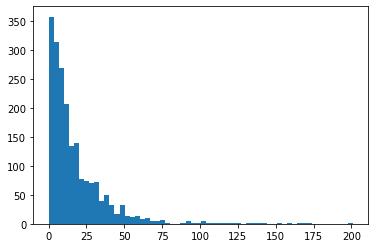

In [255]:
plt.hist(normal_training['abs_error'], bins=60)

(array([279., 281., 242., 187., 154., 117.,  94.,  88.,  55.,  63.,  64.,
         62.,  43.,  27.,  36.,  31.,   8.,  12.,  17.,  12.,   8.,   8.,
          5.,   7.,   7.,   5.,   2.,   2.,   3.,   0.,   0.,   0.,   0.,
          2.,   1.,   1.,   0.,   0.,   1.,   2.,   1.,   0.,   1.,   0.,
          0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([  0. ,   2.7,   5.4,   8.1,  10.8,  13.5,  16.2,  18.9,  21.6,
         24.3,  27. ,  29.7,  32.4,  35.1,  37.8,  40.5,  43.2,  45.9,
         48.6,  51.3,  54. ,  56.7,  59.4,  62.1,  64.8,  67.5,  70.2,
         72.9,  75.6,  78.3,  81. ,  83.7,  86.4,  89.1,  91.8,  94.5,
         97.2,  99.9, 102.6, 105.3, 108. , 110.7, 113.4, 116.1, 118.8,
        121.5, 124.2, 126.9, 129.6, 132.3, 135. , 137.7, 140.4, 143.1,
        145.8, 148.5, 151.2, 153.9, 156.6, 159.3, 162. ]),
 <BarContainer object of 60 artists>)

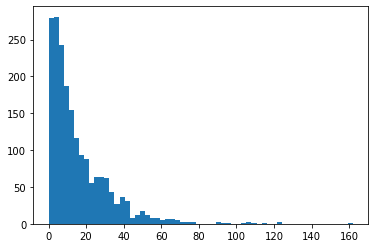

In [256]:
plt.hist(aggressive_training['abs_error'], bins=60)

(array([24., 21., 19., 26., 21., 19., 22., 20., 14., 21., 12.,  8., 10.,
         9.,  9., 13.,  9.,  3.,  6.,  3.,  4.,  5., 11.,  2.,  3.,  2.,
         1.,  0.,  3.,  3.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.16666667,  1.42222222,  2.67777778,  3.93333333,  5.18888889,
         6.44444444,  7.7       ,  8.95555556, 10.21111111, 11.46666667,
        12.72222222, 13.97777778, 15.23333333, 16.48888889, 17.74444444,
        19.        , 20.25555556, 21.51111111, 22.76666667, 24.02222222,
        25.27777778, 26.53333333, 27.78888889, 29.04444444, 30.3       ,
        31.55555556, 32.81111111, 34.06666667, 35.32222222, 36.57777778,
        37.83333333, 39.08888889, 40.34444444, 41.6       , 42.85555556,
        44.11111111, 45.36666667, 46.62222222, 47.87777778, 49.13333333,
        50.38888889, 51.64444444, 52.9       , 54.15555556, 55.41111111,
 

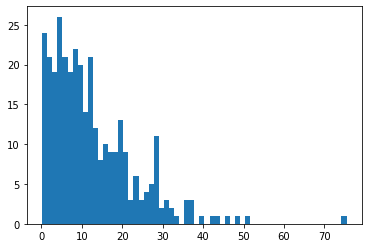

In [257]:
plt.hist(normal_training_euro['abs_error'], bins=60)

# Model Scoring and Validation (exploratory)

In [61]:
for s in species_prediction_dict.keys():
    print(s, species_prediction_dict[s]['Median Error'])

Rubus 9.5
Rubus occidentalis 6.0
Ficus 18.0
Ficus carica 13.0
Ficus citrifolia 39.5
Ficus macrophylla 7.0
Olea europaea 45.5
Olea europea 17.5
Olea 32.0
Morus rubra 15.5
Morus 15.5
Morus macroura 35.0
Morus alba 7.0
Morus nigra 11.5
Morus australis 19.0
Amelanchier alnifolia 9.0
Amelanchier arborea 28.0
Amelanchier canadensis 14.0
Amelanchier grandiflora 12.5
Amelanchier laevis 13.0
Amelanchier utahensis 30.875
Amelanchier 11.5
Citrus 111.0
Citrus jambhiri 3.0
Citrus limon 63.0
Rubus idaeus 14.5
Rubus hayata 10.0
Rubus phoenicolasius 10.0
Rubus rolfei 11.0
Citrus aurantium 13.5
Citrus sinensis 26.0
Prunus americana 37.0
Prunus domestica 15.0
Prunus maritima 14.5
Prunus nigra 55.0
Prunus cerasifera 13.5
Prunus 29.0
Prunus angustifolia 25.0
Prunus cocomilia 13.0
Prunus salicina 32.0
Prunus subcordata 8.0
Prunus mexicana 8.5
Prunus rivularis 11.0
Eriobotrya japonica 49.0
Malus sieboldii 56.0
Malus 32.0
Malus pumila 24.0
Malus domestica 9.5
Malus sylvestris 14.0
Malus coronaria 41.0
Malus 

TODO for tomorrow: figure out why it's still defaulting to monthly instead of taking some euro data. 

In [74]:
# gets a list of all the prediction dataframes from the species model
df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

full_prediction_df = pd.concat(df_list)

full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['flowering_day'])

In [99]:
for g in full_prediction_df['genus'].dropna().unique():
    g_df = full_prediction_df[full_prediction_df['genus'] == g]
    print(g)
    calc_error_percentile(g_df, full_prediction_df)

Rubus
10.0
0.6075816075816076
Ficus
16.0
0.44120744120744115
Olea
41.0
0.14215514215514213
Morus
13.0
0.5135135135135135
Amelanchier
13.0
0.5135135135135135
Citrus
110.0
0.02211302211302213
Prunus
19.0
0.3783783783783784
Eriobotrya
49.0
0.10810810810810811
Malus
30.0
0.23727623727623726
Rosmarinus
90.0
0.03404703404703402
Juglans
16.0
0.44120744120744115
Cornus
32.0
0.2169182169182169
Diospyros
17.5
0.40400140400140405
Pyrus
28.0
0.2628992628992629


In [115]:
score_model(full_prediction_df)

Error metrics:
MAE: 21.891178292476994
RMSE: 34.257129283602936
Median Absolute Error: 13.0
Median portion (median error = 13.0)
0.4864864864864865
SD portion (SD = 26.35008955811099)
0.7237627237627238
Month threshold:
0.7627237627237627
2 * SD portion (2SD = 52.70017911622198)
0.9143559143559143


In [85]:
np.std(full_prediction_df['abs_error'])

26.35008955811099

(array([470., 425., 304., 309., 200., 180., 106., 135., 102., 114.,  74.,
         57.,  38.,  56.,  45.,  22.,  24.,  15.,  17.,  10.,  17.,  11.,
          8.,   9.,   2.,  14.,   5.,   6.,   6.,   3.,   5.,  11.,   1.,
          0.,   6.,   0.,   1.,   1.,   6.,   8.,   0.,   1.,   6.,   2.,
          2.,   4.,   2.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   2.]),
 array([  0.  ,   3.55,   7.1 ,  10.65,  14.2 ,  17.75,  21.3 ,  24.85,
         28.4 ,  31.95,  35.5 ,  39.05,  42.6 ,  46.15,  49.7 ,  53.25,
         56.8 ,  60.35,  63.9 ,  67.45,  71.  ,  74.55,  78.1 ,  81.65,
         85.2 ,  88.75,  92.3 ,  95.85,  99.4 , 102.95, 106.5 , 110.05,
        113.6 , 117.15, 120.7 , 124.25, 127.8 , 131.35, 134.9 , 138.45,
        142.  , 145.55, 149.1 , 152.65, 156.2 , 159.75, 163.3 , 166.85,
        170.4 , 173.95, 177.5 , 181.05, 184.6 , 188.15, 191.7 , 195.25,
        198.8 , 202.35, 205.9 , 209.45, 213.  ]),
 <BarContainer object of 60 artists>

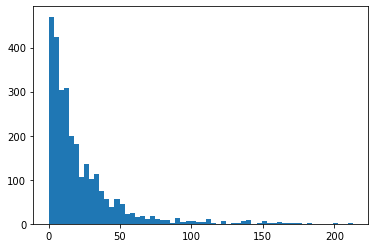

In [86]:
plt.hist(full_prediction_df['abs_error'], bins=60)

In [102]:
full_prediction_df[full_prediction_df['abs_error'] >= 100].sort_values('abs_error', ascending=False)[0:50]

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
36,8,39.910755,62.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,213.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516.0,Malus sieboldii,38.4,237.5,275,212.0
46,8,39.910755,75.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,200.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516.0,Malus,43.0,281.2,245,182.0
182,1824168,32.078188,357.0,2022.0,Citrus,34.802053,516.0,Citrus,32.1,34.8,183,174.0
193,1824165,32.026304,356.0,2022.0,Citrus,278.925524,516.0,Citrus,32.0,278.9,183,173.0
492,4,34.051340,73.0,2022.0,Olea,241.796875,516.0,Olea europaea,34.1,241.8,245,172.0
98,1823026,33.922294,289.0,2022.0,Eriobotrya,241.593083,516.0,Eriobotrya japonica,33.9,241.6,122,167.0
324869,3096,39.997452,108.0,2022.0,Malus,254.717300,516.0,Malus pumila,40.0,254.7,275,167.0
413,1824101,32.056094,349.0,2022.0,Citrus,34.799296,516.0,Citrus,32.1,34.8,183,166.0


In [103]:
full_prediction_df

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
19,1812903,42.000443,183.0,2022.0,Rubus,268.349632,516.0,Rubus,42.0,268.3,183,0.0
20,1812992,43.123822,181.0,2022.0,Rubus,282.422069,516.0,Rubus,43.1,282.4,183,2.0
22,1813012,35.219765,190.0,2022.0,Rubus,270.150501,516.0,Rubus,35.2,270.2,183,7.0
23,1813095,43.026309,193.0,2022.0,Rubus,274.317216,516.0,Rubus,43.0,274.3,183,10.0
25,1810562,37.417095,165.0,2022.0,Rubus,280.809241,516.0,Rubus,37.4,280.8,183,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1,1759647,NaN,240.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,35.0
2,1760749,NaN,271.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,4.0
0,1769198,NaN,261.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,14.0
1,1718728,NaN,281.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,6.0


In [104]:
74 / 2849

0.025974025974025976

(array([  34.,   33.,   22.,   44.,   39.,   14.,   33.,   31.,   28.,
          34.,   34.,   23.,   44.,   55.,   33.,   38.,   56.,   31.,
          31.,   48.,   46.,   35.,   21.,   47.,   38.,   46.,   55.,
          56.,   36.,   42.,   42.,   26.,   51.,   55.,   37.,   40.,
          56.,   59.,  106.,   87.,  206.,  295.,  286.,  474.,  612.,
         590.,  892.,  860.,  653.,  814.,  678.,  470.,  698.,  657.,
         616.,  709.,  868.,  590.,  962.,  581.,  771.,  767.,  502.,
         816.,  753.,  518.,  721.,  677.,  512.,  833.,  885.,  763.,
         846., 1062.,  928., 1064.,  974.,  920.,  855.,  529.,  606.,
         387.,  218.,  196.,  149.,   74.,   82.,   68.,   63.,   41.,
          45.,   49.,   48.,   49.,   24.,   50.,   28.,   26.,   24.,
          17.]),
 array([  1.  ,   4.65,   8.3 ,  11.95,  15.6 ,  19.25,  22.9 ,  26.55,
         30.2 ,  33.85,  37.5 ,  41.15,  44.8 ,  48.45,  52.1 ,  55.75,
         59.4 ,  63.05,  66.7 ,  70.35,  74.  ,  77.65,  8

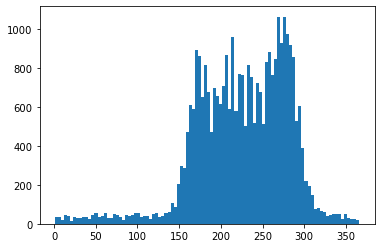

In [106]:
plt.hist(formatted_plants['doy'], bins=100)

Based on this histogram, most of the observations fall between like 150 and 315 days. Very odd. Same is true for the filtered plants. Is it just noise? 

Could probably cut off days with <20 observations (145 - 314). 

(array([ 30.,  17.,  11.,  32.,  34.,  12.,  13.,  10.,  30.,  23.,  26.,
         26.,  19.,  30.,  21.,  20.,  33.,  18.,  23.,  26.,  30.,  33.,
         22.,  27.,  39.,  56.,  66.,  89., 110., 162., 228., 283., 315.,
        527., 588., 642., 646., 626., 642., 597., 527., 499., 525., 454.,
        467., 530., 598., 540., 634., 581., 935., 573., 600., 495., 556.,
        478., 622., 528., 537., 469., 552., 460., 457., 636., 594., 614.,
        901., 704., 730., 896., 774., 686., 901., 648., 648., 494., 474.,
        298., 222., 169., 108., 106.,  70.,  68.,  46.,  57.,  43.,  24.,
         26.,  39.,  36.,  30.,  27.,  20.,  32.,  17.,  21.,  12.,  22.,
         12.]),
 array([ 60.  ,  63.06,  66.12,  69.18,  72.24,  75.3 ,  78.36,  81.42,
         84.48,  87.54,  90.6 ,  93.66,  96.72,  99.78, 102.84, 105.9 ,
        108.96, 112.02, 115.08, 118.14, 121.2 , 124.26, 127.32, 130.38,
        133.44, 136.5 , 139.56, 142.62, 145.68, 148.74, 151.8 , 154.86,
        157.92, 160.98, 164.04

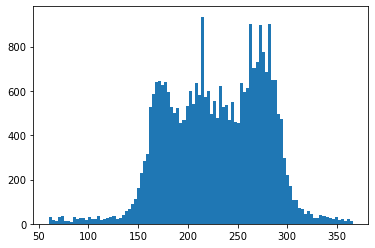

In [107]:
plt.hist(filtered_plants['doy'], bins=100)

In [110]:
dict(filtered_plants.groupby('doy').size())

{60.0: 8,
 61.0: 5,
 62.0: 6,
 63.0: 11,
 64.0: 4,
 65.0: 6,
 66.0: 7,
 67.0: 5,
 68.0: 3,
 69.0: 3,
 70.0: 8,
 71.0: 8,
 72.0: 16,
 73.0: 14,
 74.0: 4,
 75.0: 16,
 76.0: 4,
 77.0: 4,
 78.0: 4,
 79.0: 4,
 80.0: 5,
 81.0: 4,
 82.0: 3,
 83.0: 4,
 84.0: 3,
 85.0: 8,
 86.0: 6,
 87.0: 16,
 88.0: 9,
 89.0: 5,
 90.0: 9,
 91.0: 9,
 92.0: 4,
 93.0: 13,
 94.0: 8,
 95.0: 8,
 96.0: 10,
 97.0: 8,
 98.0: 5,
 99.0: 6,
 100.0: 10,
 101.0: 13,
 102.0: 7,
 103.0: 10,
 104.0: 4,
 105.0: 7,
 106.0: 8,
 107.0: 6,
 108.0: 6,
 109.0: 8,
 110.0: 12,
 111.0: 9,
 112.0: 4,
 113.0: 4,
 114.0: 9,
 115.0: 5,
 116.0: 12,
 117.0: 3,
 118.0: 8,
 119.0: 9,
 120.0: 6,
 121.0: 11,
 122.0: 10,
 123.0: 9,
 124.0: 11,
 125.0: 11,
 126.0: 11,
 127.0: 11,
 128.0: 5,
 129.0: 4,
 130.0: 13,
 131.0: 8,
 132.0: 7,
 133.0: 12,
 134.0: 12,
 135.0: 12,
 136.0: 15,
 137.0: 14,
 138.0: 25,
 139.0: 17,
 140.0: 27,
 141.0: 18,
 142.0: 21,
 143.0: 36,
 144.0: 18,
 145.0: 35,
 146.0: 32,
 147.0: 27,
 148.0: 51,
 149.0: 31,
 150.0: 74,
 1

In [111]:
aggressive_filtered_plants = filtered_plants.query('doy <= 145 and doy >= 314')

In [ ]:
genus_prediction_dict = {}

for s in tqdm(filtered_plants['genus'].unique()):
    print(s)
    species_train_df = filtered_plants.query('genus == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
    
    species_test_df = filtered_plants.query('genus == "{}" and year >= {}'.format(s, high_cutoff_year))
    
    if len(species_test_df) == 0:
        # make predictions and compare to the mean ripeness day at each site
        species_test_df = make_test_df(species_train_df)
    
    if len(species_test_df) == 0:
        print("No test data for {}".format(s))
        #print(species_test_df)
        
    predictions = train_ripeness_small(species_train_df, weather_training,
                        species_test_df, weather_test)
    
    genus_prediction_dict[s] = predictions